<a href="https://colab.research.google.com/github/AbhiramDream/GDAL_PROJECT/blob/main/GDAL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

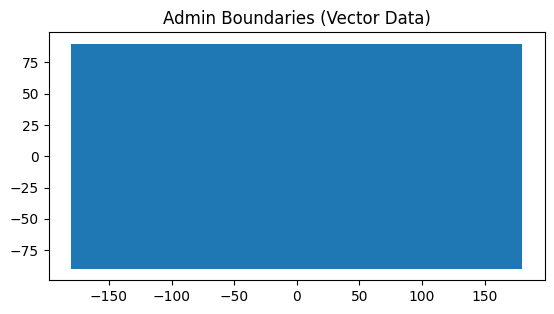

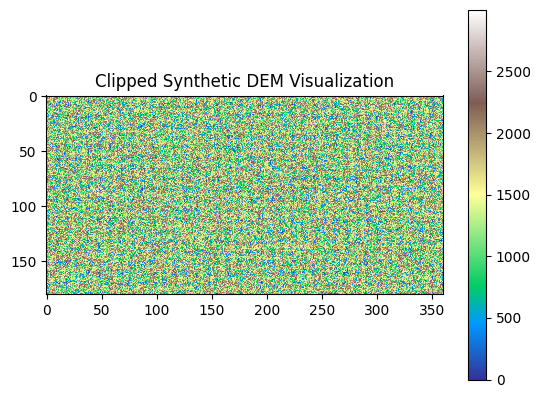

In [17]:

!pip install geopandas rasterio matplotlib numpy

import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from osgeo import osr
from shapely.geometry import Polygon
from rasterio.mask import mask
from rasterio.transform import from_origin

# Step 1: Create Synthetic Vector Data (Simple Polygon)
polygon = Polygon([(-180, -90), (-180, 90), (180, 90), (180, -90), (-180, -90)])
gdf = gpd.GeoDataFrame({'geometry': [polygon]})
gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)  # Set to WGS84

# Visualize the vector data (admin boundary)
gdf.plot()
plt.title("Admin Boundaries (Vector Data)")
plt.show()

# Step 2: Create Synthetic Raster Data (e.g., DEM)
# We will create a simple 360x180 raster grid (mimicking the DEM grid)
width = 360  # Longitude
height = 180  # Latitude

# Create synthetic raster data (elevation values)
raster_data = np.random.randint(0, 3000, size=(height, width))  # Random values between 0 and 3000 (elevation)

# Define metadata for the synthetic raster
transform = from_origin(-180, 90, 1, 1)  # Upper-left corner at (-180, 90), cell size = 1 degree

# Create the synthetic raster file using rasterio
output_raster = "/content/synthetic_dem.tif"

with rasterio.open(output_raster, 'w', driver='GTiff', height=height, width=width, count=1, dtype=raster_data.dtype, crs="EPSG:4326", transform=transform) as dst:
    dst.write(raster_data, 1)

# Step 3: Reproject Vector Data to Match Raster CRS
# Load the synthetic raster to get its CRS and transform
with rasterio.open(output_raster) as src:
    raster_crs = osr.SpatialReference()
    # Use src.crs.wkt instead of src.crs_wkt
    raster_crs.ImportFromWkt(src.crs.wkt)

# Reproject vector data to match raster CRS
gdf_reprojected = gdf.to_crs(raster_crs.ExportToProj4())

# Step 4: Clip Raster Using Vector Data (Polygon)
with rasterio.open(output_raster) as src:
    out_image, out_transform = mask(src, gdf_reprojected.geometry, crop=True)
    out_meta = src.meta.copy()

# Update metadata with new dimensions and transform after clipping
out_meta.update({"driver": "GTiff", "count": 1, "dtype": "float32", "crs": raster_crs.ExportToWkt(), "transform": out_transform})

# Save the clipped raster
clipped_raster = "/content/clipped_synthetic_dem.tif"
with rasterio.open(clipped_raster, "w", **out_meta) as dest:
    dest.write(out_image)

# Step 5: Visualize Clipped Raster Data
plt.imshow(out_image[0], cmap='terrain')
plt.colorbar()
plt.title("Clipped Synthetic DEM Visualization")
plt.show()


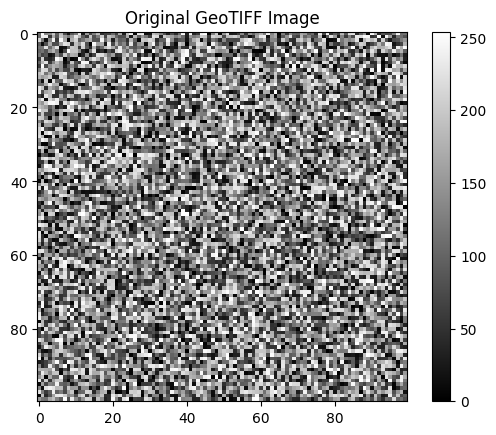

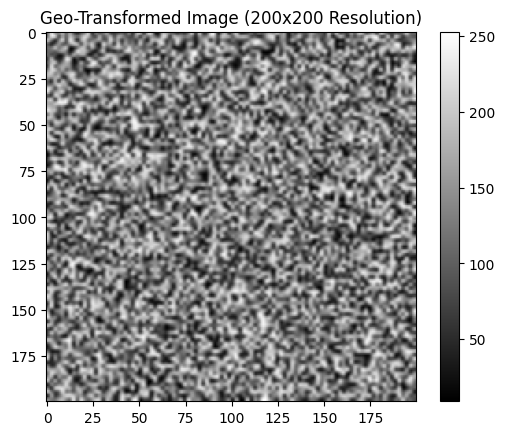

Original Transform: | 1.00, 0.00,-180.00|
| 0.00,-1.00, 90.00|
| 0.00, 0.00, 1.00|
New Transform: | 0.50, 0.00,-180.00|
| 0.00,-0.50, 90.00|
| 0.00, 0.00, 1.00|
Original CRS: EPSG:4326


In [19]:

import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.transform import from_origin
from rasterio.enums import Resampling

# Step 1: Create a Synthetic GeoTIFF Raster (Example Image)
# We will create a synthetic image (random values) with georeferencing info

width = 100
height = 100

# Create synthetic raster data (random values)
data = np.random.randint(0, 255, size=(height, width), dtype=np.uint8)  # 100x100 random image data

# GeoTIFF metadata
transform = from_origin(-180, 90, 1, 1)  # Top-left corner (-180, 90), pixel size of 1x1 degree
crs = 'EPSG:4326'  # WGS 84 coordinate system (latitude/longitude)

# Define the output raster file
output_raster = '/content/synthetic_geotiff.tif'

# Write the synthetic raster data to a GeoTIFF file
with rasterio.open(output_raster, 'w', driver='GTiff', height=height, width=width,
                   count=1, dtype=data.dtype, crs=crs, transform=transform) as dst:
    dst.write(data, 1)

# Step 2: Load and Visualize the Original Image
with rasterio.open(output_raster) as src:
    # Read the raster data and get the transform and CRS
    original_data = src.read(1)
    original_transform = src.transform
    original_crs = src.crs

# Plot the original image (before transformation)
plt.imshow(original_data, cmap='gray')
plt.title('Original GeoTIFF Image')
plt.colorbar()
plt.show()

# Step 3: Apply Geo-Transformation to the Image
new_transform = from_origin(-180, 90, 0.5, 0.5)

# Resample the data to the new resolution using rasterio's resampling
with rasterio.open(output_raster) as src:

    original_data = src.read(1)


    new_width = 200
    new_height = 200

    # Create a new transform for the scaled resolution
    resampled_data = src.read(
        1,
        out_shape=(new_height, new_width),  # Reshape to 200x200
        resampling=Resampling.bilinear
    )

    # Apply the new transform to adjust the image
    new_data = resampled_data

# Step 4: Visualize the Transformed Image
plt.imshow(new_data, cmap='gray')
plt.title('Geo-Transformed Image (200x200 Resolution)')
plt.colorbar()
plt.show()
# Step 5: Print the Original and New Transform Information
with rasterio.open(output_raster) as src:
    print(f"Original Transform: {src.transform}")
    print(f"New Transform: {new_transform}")
    print(f"Original CRS: {src.crs}")